In [114]:
# import a custom plotting library
#import some_plotters as plotter
import matplotlib.pyplot as plt

# import autograd functionality
import autograd.numpy as np

# import path to datasets
datapath = 'datasets/'

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# autoreload functi"on - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

#Other Imports
from autograd import value_and_grad 
from autograd.misc.flatten import flatten_func

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### <span style="color:#a50e3e;">Exercise 1: </span>  Perform Imitation Learning on a small chunk of cruise control data 

In this exercise you will perform Imitation Learning using a small snippet of cruise control data shown below.  Here our `output sequence` are states $\left\{s_t\right\}_{t=1}^T$, and the `input sequence` corresponding actions $\left\{a_t\right\}_{t=1}^{T-1}$ (we can ignore any finanl action $a_T$ since there is no next state $s_{t+1}$ to regress it on in learning our system model).  Notice at each update step the action is clipped to lie in the range $[-50,100]$ - which is the angle of the pedal against the floor of the car.  Here a negative angle indicates that 'regenerative braking' was applied.

In [115]:
# load in cruise control data
data = np.loadtxt(datapath + 'simulated_car_data.csv',delimiter = ',')

# extract actions and states 
actions = data[0,1:][np.newaxis,:] # our T-1 actions
states = data[1,:][np.newaxis,:]   # our T states

# plot the test pair
#plotter.plot_pair(actions,states)

Some more particulars: here you need to learn the weights of a basic order $1$ linear system model - which takes the form

\begin{equation}
s_{t+1} = f_{\text{imitator}}\left(s_t,a_t\right) = w_0 + w_1s_t + w_2a_t
\end{equation}

by properly minimizing the associated Least Squares cost function

\begin{equation}
\frac{1}{T-1}\sum_{t=1}^{T-1}\left(f_{\text{imitator}}\left(s_t,a_t\right) - s_{t+1}\right)^2
\end{equation}

over the weights $\left\{ w_0,\, w_1,\, w_2\right\}$ where $T$ is the length of our training action sequence.  


- Build a `Python` version of the system model and Least Squares cost function and minimize it using a first order method.  Use the entire dataset provided for training (i.e., do not worry about validation error)


- After properly minimizing the Least Squares cost above make a plot like the one shown below - which shows the original state data in black, and the system model approximation in blue.  Your trained model should be able to match the data quite well.

<figure>
<p>
<img src= 'images/cruise_control_approximate.png' width="150%" height="150%" alt=""/>
</p>
</figure>

In [116]:
#pull the gradient descent function from the helper functions notebook
def gradient_descent(g,w_init,alpha,max_its,verbose): 
    # flatten the input function
    g_flat, unflatten, w = flatten_func(g, w_init)
    
    # compute gradient of flattened input function
    # when evaluated this returns both the evaluation of the gradient and the original function
    grad = value_and_grad(g_flat)
    cost_eval,grad_eval = grad(w)
    grad_eval.shape = np.shape(w)

    # record history
    w_hist = [unflatten(w)]
    train_hist = [cost_eval]
        
    # gradient descent loop
    for k in range(max_its): 
        # take descent step with momentum
        w = w - alpha*grad_eval
        
        # plug in updated w into func and gradient
        cost_eval,grad_eval = grad(w)
        grad_eval.shape = np.shape(w)
                
        # store updates
        w_hist.append(unflatten(w))
        train_hist.append(cost_eval)

        # print update
        if verbose == True:
            print ('step ' + str(k+1) + ' complete, train cost = ' + str(np.round(train_hist[-1],4)[0]))

    # print update and return
    if verbose == True:
        print ('finished all ' + str(max_its) + ' steps')
    return w_hist,train_hist

In [117]:
# standard normalization function 
def standard_normalizer(x):
    # compute the mean and standard deviation of the input
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_stds = np.std(x,axis = 1)[:,np.newaxis]   

    # check to make sure thta x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(x_stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind]
        adjust = np.zeros((x_stds.shape))
        adjust[ind] = 1.0
        x_stds += adjust

    # create standard normalizer function
    normalizer = lambda data: (data - x_means)/x_stds

    # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

In [118]:
#Define the model as set above
def model(s,a,w):
    b = w[0] + s*w[1] + a*w[2]
    return b

#Define the least squares cost function
def least_squares(s,a,w):
    cost = 0
    T = len(s)
    s_t   = s[0:T-1]
    s_tp1 = s[1:T]
    cost = np.sum((model(s_t,a,w) - s_tp1)**2)
    return cost/(T-1)

In [184]:
# Retrieve the normalize and inverse normalize functions for the states and actions
norm_fun_s, invnorm_fun_s = standard_normalizer(states)
norm_fun_a, invnorm_fun_a = standard_normalizer(actions)

# Normalize the states, actions for fitting 
normedstates = norm_fun_s(states.T)
normedactions = norm_fun_a(actions.T)

In [189]:
#Gradient Descent Params 
w_init = np.random.randn(3,1)
alpha = 10**(-1)
max_its = 100
verbose = False

#Make an instance of Least Squares with the data locked in
g = lambda w, a = normedactions, s = normedstates: least_squares(s,a,w)

#Run gradient descent 
whx,thx = gradient_descent(g, w_init, alpha, max_its, verbose)

In [190]:
#Find the best of the weights
ind = np.argmin(thx)
w_best = whx[ind]
gbest = thx[ind]
#Print the best cost and the best weights
print("--Best Cost--")
print(gbest)
print("--Best Weights--")
print(w_best)

--Best Cost--
[ 0.00039374]
--Best Weights--
[[ 0.00330103]
 [ 0.91391149]
 [ 0.09447136]]


<IPython.core.display.Javascript object>


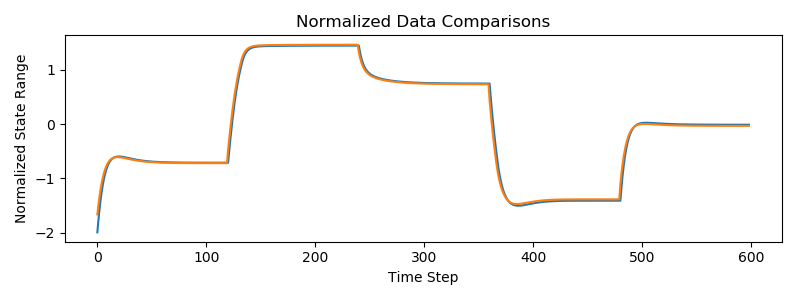

-- Mean of Squared Error --
4.96619039156e-06


In [231]:
#Test the model with normalized data  - this is for testing 
outputs = model(normedstates[0:599],normedactions, w_best)
a = normedstates[0:599]
b = normedactions
err = outputs - a
plt.figure(num=1,figsize = (8,3))
plt.title("Normalized Data Comparisons")
plt.xlabel("Time Step")
plt.ylabel("Normalized State Range")
ax1 = plt.plot(a)
plt.plot(outputs)
print("-- Mean of Squared Error --")
print(np.mean(err**2)/len(err))

<IPython.core.display.Javascript object>


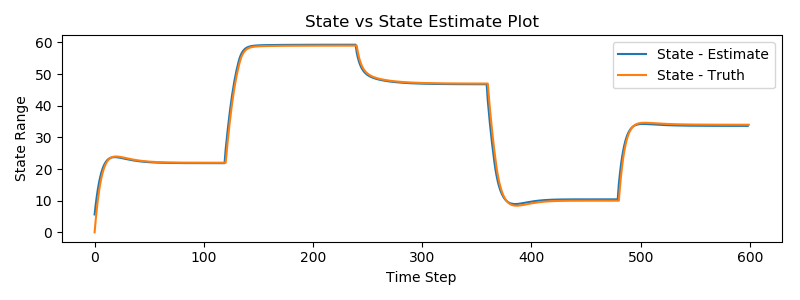

-- Mean of Squared Error --
0.00147027645755


<IPython.core.display.Javascript object>


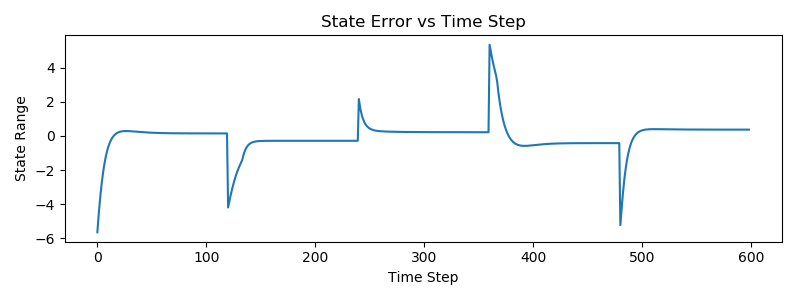

In [255]:
# ---- SOLUTION ---- 

#Run the model with the normalized data to grab the states
#based on the model
state_estimate_normed = model(normedstates[0:599],normedactions, w_best)

#Unnormalize the states
state_estimate_unnormed = invnorm_fun_s(state_estimate_normed)

#Plot Labels and Setup
plt.figure(num=2,figsize = (8,3))
plt.title("State vs State Estimate Plot")
plt.xlabel("Time Step")
plt.ylabel("State Range")
#Plot the unnormalized state estimates
plt.plot(state_estimate_unnormed)

#Plot the input states
plt.plot(states.T)

#Legend and Display
plt.legend(["State - Estimate", "State - Truth"])
plt.show()

#Compute the error function
states_tp = states.T
err_states_unnormed = states_tp[0:599] - state_estimate_unnormed

#Compute the mean of the squared error
print("-- Mean of Squared Error --")
print(np.mean(err_states_unnormed**2)/len(err))

#For fun, plot the error vector

#Plot Labels and Setup
plt.figure(num=3,figsize = (8,3))
plt.title("State Error vs Time Step")
plt.xlabel("Time Step")
plt.ylabel("State Range")

#Plot the input states
plt.plot(err_states_unnormed)

#Display 
plt.show()